In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from matplotlib import pyplot
import shap

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
import gc
import json
pd.set_option('display.max_columns', 1000)

data/sample_submission.csv
data/train_labels.csv
data/test.csv
data/data-science-bowl-2019.zip
data/train.csv
data/specs.csv


# Objective

* In the last notebook we create our baseline model including a feature selection part. 
* Cohen cappa score of 0.456 (lb) with a local cv score of 0.529
* In this notebook we are going to add more features and remove others that i think they overfitt the train set and then check if our local cv score improve.
* Next, we will check if this improvement aligns with the lb.

# Notes
* Check the distribution of the target variable of the out of folds score and the prediction distribution. A good model should more or less have the same distribution.

In [3]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [4]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [5]:
def read_data():
    base_dir = 'data/'
    print('Reading train.csv file....')
    train = pd.read_csv(base_dir + 'train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv(base_dir + 'test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv(base_dir + 'train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv(base_dir + 'specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv(base_dir + 'sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [6]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

media_sequence = {'Welcome to Lost Lagoon!': 19, 'Tree Top City - Level 1':17, 'Ordering Spheres':61, 'Costume Box':61,'12 Monkeys':109, 'Tree Top City - Level 2':25, "Pirate's Tale":80, 
                  'Treasure Map':156, 'Tree Top City - Level 3':26, 'Rulers':126, 'Magma Peak - Level 1':20, 'Slop Problem':60, 'Magma Peak - Level 2':22, 'Crystal Caves - Level 1':18, 
                  'Balancing Act':72,'Lifting Heavy Things':118, 'Crystal Caves - Level 2':24, 'Honey Cake':142, 'Crystal Caves - Level 3':19, 'Heavy, Heavier, Heaviest':61}

In [7]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    user_clip_time = []
    user_activity_time = []
    user_game_time = []
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
    time_spent_each_act = {t+"_time": 0 for t in list_of_user_activities}
        
    # last features
    sessions_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
        
        if(session_type=='Clip'):
            time_spent = media_sequence[session_title_text]
            user_clip_time.append(time_spent)
            time_spent_each_act[activities_labels[session_title] + "_time"] += time_spent
            
        elif(session_type=='Activity'):
            time_spent = (session.iloc[-1, 2] - session.iloc[0, 2]).seconds
            user_activity_time.append(time_spent)
            time_spent_each_act[activities_labels[session_title] + "_time"] += time_spent
        
        elif (session_type == 'Game'):
            time_spent = (session.iloc[-1, 2] - session.iloc[0, 2]).seconds
            user_game_time.append(time_spent)
            time_spent_each_act[activities_labels[session_title] + "_time"] += time_spent
                    
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features.update(time_spent_each_act.copy())
            features['installation_session_count'] = sessions_count
            
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                 
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)   
                
            if user_clip_time == []:
                features['clip_time_mean'] = 0
            else:
                features['clip_time_mean'] = np.mean(user_clip_time)
            if user_activity_time == []:
                features['activity_time_mean'] = 0
            else:
                features['activity_time_mean'] = np.mean(user_activity_time)
            if user_game_time == []:
                features['game_time_mean'] = 0
            else:
                features['game_time_mean'] = np.mean(user_game_time)
                
            time_spent = (session.iloc[-1, 2] - session.iloc[0, 2]).seconds
            time_spent_each_act[activities_labels[session_title] + "_time"] += time_spent
            durations.append(time_spent)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [8]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [9]:
def preprocess(reduce_train, reduce_test):
    for df in [reduce_train, reduce_test]:
        df['installation_session_count'] = df.groupby(['installation_id'])['Clip'].transform('count')
        df['installation_duration_mean'] = df.groupby(['installation_id'])['duration_mean'].transform('mean')
        #df['installation_duration_std'] = df.groupby(['installation_id'])['duration_mean'].transform('std')
        df['installation_title_nunique'] = df.groupby(['installation_id'])['session_title'].transform('nunique')
        
        df['sum_event_code_count'] = df[[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 
                                        4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 
                                        2040, 4090, 4220, 4095]].sum(axis = 1)
        
        df['installation_event_code_count_mean'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('mean')
        #df['installation_event_code_count_std'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('std')
        
    features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
    features = [x for x in features if x not in ['accuracy_group', 'installation_id']] + ['acc_' + title for title in assess_titles]
   
    return reduce_train, reduce_test, features

In [10]:
class Base_Model(object):
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            # 相当于降维
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]   
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            # 针对不同模型处理数据
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            # 针对不同模型训练数据
            model = self.train_model(train_set, val_set) 
            # 针对不同模型预测数据
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            # 得到测试数据
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, loss_score, model

In [39]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':2000,
                  'boosting_type': 'gbdt',
                  'objective': 'regression',
                  'metric': 'rmse',
                  'subsample': 0.75,
                  'subsample_freq': 1,
                  'learning_rate': 0.01,
                  'feature_fraction': 0.9,
                  'max_depth': 15,
                  'lambda_l1': 1,  
                  'lambda_l2': 1,
                  'early_stopping_rounds': 100}
        return params

In [40]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'colsample_bytree': 0.8,                 
                  'learning_rate': 0.01,
                  'max_depth': 10,
                  'subsample': 1,
                  'objective':'reg:squarederror',
                  #'eval_metric':'rmse',
                  'min_child_weight':3,
                  'gamma':0.25,
                  'n_estimators':2000}
        return params

In [44]:
class Catb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        clf = CatBoostRegressor(**self.params)
        clf.fit(train_set['X'], 
                train_set['y'], 
                eval_set=(val_set['X'], val_set['y']),
                verbose=verbosity, 
                cat_features=self.categoricals)
        return clf
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        params = {'loss_function': 'RMSE',
                   'task_type': "CPU",
                   'iterations': 2000,
                   'od_type': "Iter",
                   'depth': 10,
                   'colsample_bylevel': 0.5, 
                   'early_stopping_rounds': 300,
                   'l2_leaf_reg': 18,
                   'random_seed': 42,
                   'use_best_model': True}
        return params

In [14]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

class Nn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        print(train_df[features].shape)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set['X'].shape[1],)),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='relu')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

In [15]:
from random import choice

class Cnn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        self.create_feat_2d(features)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def create_feat_2d(self, features, n_feats_repeat=50):
        self.n_feats = len(features)
        self.n_feats_repeat = n_feats_repeat
        self.mask = np.zeros((self.n_feats_repeat, self.n_feats), dtype=np.int32)
        for i in range(self.n_feats_repeat):
            l = list(range(self.n_feats))
            for j in range(self.n_feats):
                c = l.pop(choice(range(len(l))))
                self.mask[i, j] = c
        self.mask = tf.convert_to_tensor(self.mask)
        print(self.mask.shape)
       
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0

        inp = tf.keras.layers.Input(shape=(self.n_feats))
        x = tf.keras.layers.Lambda(lambda x: tf.gather(x, self.mask, axis=1))(inp)
        x = tf.keras.layers.Reshape((self.n_feats_repeat, self.n_feats, 1))(x)
        x = tf.keras.layers.Conv2D(18, (50, 50), strides=50, activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        #x = tf.keras.layers.Dense(200, activation='relu')(x)
        #x = tf.keras.layers.LayerNormalization()(x)
        #x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(100, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(50, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        out = tf.keras.layers.Dense(1)(x)
        
        model = tf.keras.Model(inp, out)
    
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

In [16]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, \
list_of_event_code, activities_labels, assess_titles, list_of_event_id,\
all_title_event_code = encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)
reduce_train.shape, reduce_test.shape, categoricals

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0.028296339811674016


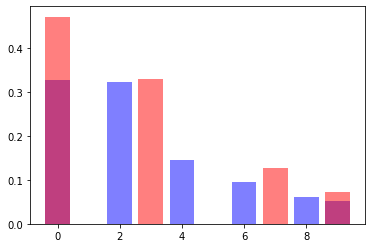

0.028296339811674016

In [17]:
def stract_hists(feature, train=reduce_train, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre
stract_hists('Magma Peak - Level 1_2000', adjust=True, plot=True)

In [18]:
# call feature engineering function
reduce_train, reduce_test, features = preprocess(reduce_train, reduce_test)

In [21]:
reduce_train.shape, reduce_test.shape, len(features)

((17690, 952), (1000, 952), 943)

In [23]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [27]:
counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
#             c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]   
            c = np.abs(np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1])  
            if c > 0.95:  # 相关性
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

1: FEAT_A: Clip FEAT_B: 2000 - Correlation: 0.9721373682280366
2: FEAT_A: Clip FEAT_B: 27253bdc - Correlation: 0.9999999999999999
3: FEAT_A: Activity FEAT_B: 3110 - Correlation: 0.9414937632770811
4: FEAT_A: Activity FEAT_B: 4020 - Correlation: 0.9260165437526364
5: FEAT_A: Activity FEAT_B: 4025 - Correlation: 0.9035085734905595
6: FEAT_A: Activity FEAT_B: 4030 - Correlation: 0.9204993219660975
7: FEAT_A: Activity FEAT_B: 3010 - Correlation: 0.9434185442500742
8: FEAT_A: Activity FEAT_B: 2020 - Correlation: 0.9106383777731372
9: FEAT_A: Activity FEAT_B: accumulated_actions - Correlation: 0.94036541945382
10: FEAT_A: Activity FEAT_B: sum_event_code_count - Correlation: 0.94036541945382
11: FEAT_A: Assessment FEAT_B: c74f40cd - Correlation: 0.9353605103224556
12: FEAT_A: Assessment FEAT_B: 5f0eb72c - Correlation: 0.9051489486753574
13: FEAT_A: Assessment FEAT_B: 3dfd4aa4 - Correlation: 0.9378099307200437
14: FEAT_A: Assessment FEAT_B: a52b92d5 - Correlation: 0.9263666374959029
15: FEAT_A

113: FEAT_A: 4031 FEAT_B: Dino Drink_3021 - Correlation: 0.9794401872513219
114: FEAT_A: 4031 FEAT_B: Dino Drink_2020 - Correlation: 0.9825329508178564
115: FEAT_A: 4031 FEAT_B: Dino Drink_3121 - Correlation: 0.9786708512200631
116: FEAT_A: 4031 FEAT_B: Dino Drink_4031 - Correlation: 1.0
117: FEAT_A: 4031 FEAT_B: Dino Drink_2030 - Correlation: 0.980464926458165
118: FEAT_A: 4031 FEAT_B: Dino Drink_3110 - Correlation: 0.939221260861279
119: FEAT_A: 4045 FEAT_B: 37db1c2f - Correlation: 0.9399266303814485
120: FEAT_A: 4045 FEAT_B: Happy Camel_4045 - Correlation: 0.9399266303814485
121: FEAT_A: 4050 FEAT_B: a1192f43 - Correlation: 0.9999999999999999
122: FEAT_A: 4050 FEAT_B: Crystals Rule_4050 - Correlation: 0.9999999999999999
123: FEAT_A: 2010 FEAT_B: accumulated_correct_attempts - Correlation: 0.9868159502199594
124: FEAT_A: 2010 FEAT_B: 3 - Correlation: 0.9207958081008428
125: FEAT_A: 2025 FEAT_B: 2035 - Correlation: 0.9187742090873994
126: FEAT_A: 4220 FEAT_B: 1340b8d7 - Correlation: 1

225: FEAT_A: 6cf7d25c FEAT_B: Pan Balance_4100 - Correlation: 0.9597081925333956
226: FEAT_A: 6cf7d25c FEAT_B: Pan Balance_4020 - Correlation: 0.9409006515941704
227: FEAT_A: 6cf7d25c FEAT_B: Pan Balance_3010 - Correlation: 1.0
228: FEAT_A: 6cf7d25c FEAT_B: Pan Balance_3121 - Correlation: 0.9813699377572669
229: FEAT_A: 6cf7d25c FEAT_B: Pan Balance_3110 - Correlation: 0.9994848234397947
230: FEAT_A: 6cf7d25c FEAT_B: Pan Balance_4025 - Correlation: 0.956745381927875
231: FEAT_A: 6cf7d25c FEAT_B: Pan Balance_2020 - Correlation: 0.986987556559287
232: FEAT_A: 6cf7d25c FEAT_B: Pan Balance_3021 - Correlation: 0.9817911653418252
233: FEAT_A: 6cf7d25c FEAT_B: Pan Balance_2030 - Correlation: 0.9816766553899514
234: FEAT_A: 3ee399c3 FEAT_B: Cauldron Filler (Assessment)_4070 - Correlation: 1.0
235: FEAT_A: f32856e4 FEAT_B: 29f54413 - Correlation: 0.9331833608695493
236: FEAT_A: f32856e4 FEAT_B: 3afde5dd - Correlation: 0.9503556673450437
237: FEAT_A: f32856e4 FEAT_B: b012cd7f - Correlation: 0.950

331: FEAT_A: 84b0e0c8 FEAT_B: Chicken Balancer (Activity) - Correlation: 0.9391482988992905
332: FEAT_A: 84b0e0c8 FEAT_B: Chicken Balancer (Activity)_4030 - Correlation: 0.9114216762037565
333: FEAT_A: 84b0e0c8 FEAT_B: Chicken Balancer (Activity)_3010 - Correlation: 0.9993007600205109
334: FEAT_A: 84b0e0c8 FEAT_B: Chicken Balancer (Activity)_3110 - Correlation: 1.0
335: FEAT_A: 77261ab5 FEAT_B: Sandcastle Builder (Activity)_2000 - Correlation: 0.9999999999999999
336: FEAT_A: a7640a16 FEAT_B: Happy Camel_4070 - Correlation: 1.0
337: FEAT_A: 51311d7a FEAT_B: c6971acf - Correlation: 0.9931665515650936
338: FEAT_A: 51311d7a FEAT_B: 5be391b5 - Correlation: 0.9603085236971819
339: FEAT_A: 51311d7a FEAT_B: Dino Drink_4010 - Correlation: 0.9603085236971819
340: FEAT_A: 51311d7a FEAT_B: Dino Drink_2000 - Correlation: 1.0
341: FEAT_A: 51311d7a FEAT_B: Dino Drink_2060 - Correlation: 0.9931665515650936
342: FEAT_A: 7da34a02 FEAT_B: Mushroom Sorter (Assessment)_4070 - Correlation: 0.999999999999999

432: FEAT_A: 49ed92e9 FEAT_B: bd701df8 - Correlation: 0.9993109138888533
433: FEAT_A: 49ed92e9 FEAT_B: Watering Hole (Activity)_3010 - Correlation: 1.0
434: FEAT_A: 49ed92e9 FEAT_B: Watering Hole (Activity)_3110 - Correlation: 0.9993109138888533
435: FEAT_A: f93fc684 FEAT_B: 7d093bf9 - Correlation: 0.9916710892741648
436: FEAT_A: f93fc684 FEAT_B: Chow Time_2000 - Correlation: 0.9916710892741648
437: FEAT_A: f93fc684 FEAT_B: Chow Time_4010 - Correlation: 0.9999999999999999
438: FEAT_A: 6043a2b4 FEAT_B: All Star Sorting_4090 - Correlation: 0.9999999999999999
439: FEAT_A: 67aa2ada FEAT_B: Leaf Leader_4090 - Correlation: 1.0
440: FEAT_A: e4f1efe6 FEAT_B: 222660ff - Correlation: 0.9984044689083383
441: FEAT_A: e4f1efe6 FEAT_B: 38074c54 - Correlation: 0.9984044689083383
442: FEAT_A: e4f1efe6 FEAT_B: 3afb49e6 - Correlation: 0.9985179906980773
443: FEAT_A: e4f1efe6 FEAT_B: Chest Sorter (Assessment)_2030 - Correlation: 0.9984044689083383
444: FEAT_A: e4f1efe6 FEAT_B: Chest Sorter (Assessment)_3

538: FEAT_A: 9ce586dd FEAT_B: Chest Sorter (Assessment)_4035 - Correlation: 1.0
539: FEAT_A: c952eb01 FEAT_B: Watering Hole (Activity)_4070 - Correlation: 1.0
540: FEAT_A: 1b54d27f FEAT_B: Watering Hole (Activity)_2010 - Correlation: 1.0
541: FEAT_A: bd612267 FEAT_B: Chest Sorter (Assessment)_4070 - Correlation: 0.9999999999999999
542: FEAT_A: 63f13dd7 FEAT_B: 7ec0c298 - Correlation: 0.9345744459261818
543: FEAT_A: 63f13dd7 FEAT_B: 0d1da71f - Correlation: 0.9264608480019237
544: FEAT_A: 63f13dd7 FEAT_B: Chow Time_3110 - Correlation: 0.9264608480019237
545: FEAT_A: 63f13dd7 FEAT_B: Chow Time_3010 - Correlation: 0.9345744459261818
546: FEAT_A: 63f13dd7 FEAT_B: Chow Time_2020 - Correlation: 1.0
547: FEAT_A: 9de5e594 FEAT_B: 28a4eb9a - Correlation: 0.9995923561196808
548: FEAT_A: 9de5e594 FEAT_B: Dino Dive_3020 - Correlation: 1.0
549: FEAT_A: 9de5e594 FEAT_B: Dino Dive_3120 - Correlation: 0.9995923561196808
550: FEAT_A: 4901243f FEAT_B: Fireworks (Activity)_2000 - Correlation: 1.0
551: FEA

643: FEAT_A: Crystal Caves - Level 3 FEAT_B: Crystal Caves - Level 2 - Correlation: 0.911885684429724
644: FEAT_A: Crystal Caves - Level 3 FEAT_B: Crystal Caves - Level 3_2000 - Correlation: 1.0
645: FEAT_A: Crystal Caves - Level 3 FEAT_B: Crystal Caves - Level 2_2000 - Correlation: 0.911885684429724
646: FEAT_A: Crystal Caves - Level 3 FEAT_B: Crystal Caves - Level 3_time - Correlation: 1.0
647: FEAT_A: Crystal Caves - Level 3 FEAT_B: Crystal Caves - Level 2_time - Correlation: 0.9118856844297207
648: FEAT_A: Lifting Heavy Things FEAT_B: Lifting Heavy Things_2000 - Correlation: 0.9999999999999999
649: FEAT_A: Lifting Heavy Things FEAT_B: Lifting Heavy Things_time - Correlation: 1.0
650: FEAT_A: Rulers FEAT_B: Rulers_2000 - Correlation: 1.0
651: FEAT_A: Rulers FEAT_B: Rulers_time - Correlation: 1.0
652: FEAT_A: Magma Peak - Level 2 FEAT_B: Magma Peak - Level 2_2000 - Correlation: 1.0
653: FEAT_A: Magma Peak - Level 2 FEAT_B: Magma Peak - Level 2_time - Correlation: 0.9999999999999989
6

In [28]:
to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

acc_Cart Balancer (Assessment) -0.04020325710970143 -0.47065833333333335 0.006732930476733109


divide by zero encountered in double_scalars


29a42aea 0.004070096099491238 0.0


invalid value encountered in double_scalars


4074bac2 0.0 0.0
6aeafed4 0.14703222159412097 0.008 0.0
e4d32835 0.0013001695873374789 0.0
5dc079d8 0.0 0.0


divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


ecc6157f 0.007292255511588468 0.0
eb2c19cd 0.17382702091577162 0.008 0.0
13f56524 0.04392312040700961 0.0
ab4ec3a4 0.0009044657998869418 0.0


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars


1b54d27f 0.0007348784624081402 0.0
003cd2ee 0.0 0.0


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


7fd1ac25 0.01978518937252685 0.0
bfc77bd6 0.012832108535895986 0.0


divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars


119b5b02 0.0002826455624646693 0.0
17ca3959 0.0 0.0
2ec694de 0.008988128886376484 0.0
0ce40006 0.0008479366873940079 0.0


invalid value encountered in double_scalars
divide by zero encountered in double_scalars


a8cc6fec 0.0 0.0
01ca3a3c 0.0004522328999434709 0.0


divide by zero encountered in double_scalars


611485c5 0.0013566986998304127 0.0


invalid value encountered in double_scalars


dcb1663e 0.0 0.0


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Egg Dropper (Activity)_4080 0.01978518937252685 0.0
Dino Drink_4080 0.0009044657998869418 0.0
Bubble Bath_4090 0.14703222159412097 0.008 0.0
Bug Measurer (Activity)_4080 0.008988128886376484 0.0
Dino Dive_4080 0.0002826455624646693 0.0


divide by zero encountered in double_scalars
invalid value encountered in double_scalars


Chest Sorter (Assessment)_4080 0.012832108535895986 0.0
Mushroom Sorter (Assessment)_4080 0.04392312040700961 0.0
Air Show_4080 0.0 0.0
Mushroom Sorter (Assessment)_4090 0.17382702091577162 0.008 0.0


divide by zero encountered in double_scalars


Pan Balance_4080 0.0013001695873374789 0.0


invalid value encountered in double_scalars


Sandcastle Builder (Activity)_2010 0.0 0.0


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Bubble Bath_4080 0.004070096099491238 0.0
Leaf Leader_4080 0.0004522328999434709 0.0


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Happy Camel_4080 0.0008479366873940079 0.0
Cart Balancer (Assessment)_4080 0.007292255511588468 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars


Pan Balance_2010 0.0 0.0
Crystals Rule_2010 0.0 0.0
Watering Hole (Activity)_2010 0.0007348784624081402 0.0


divide by zero encountered in double_scalars


Fireworks (Activity)_4080 0.0013566986998304127 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars


Scrub-A-Dub_4080 0.0 0.0
Bottle Filler (Activity)_2010 0.0 0.0
Chest Sorter (Assessment)_time 452.7551158846806 36.574 0.007628145048781528
installation_session_count 14.58383267382702 1.0 0.1127006932086135


In [41]:
features = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features].shape, ajusted_test.shape, len(features), categoricals

((17690, 239), (1000, 952), 239, ['session_title'])

In [42]:
reduce_train[features]

,Clip,Activity,Assessment,Game,acc_Chest_Sorter__Assessment_,acc_Mushroom_Sorter__Assessment_,acc_Cauldron_Filler__Assessment_,acc_Bird_Measurer__Assessment_,2050,4100,4230,5000,2060,4110,2070,2075,2081,3120,3121,4021,4022,4031,4035,4040,4045,4050,2010,4070,2025,4080,4090,4220,4095,cf82af56,4b5efe37,d45ed6a1,3d0b9317,71fe8f75,14de4c5d,6f4adc4b,8d84fa81,c7128948,bc8f2793,25fa8af4,b2e5b0f1,6cf7d25c,3ee399c3,f32856e4,daac11b0,e5734469,90efca10,02a42007,832735e1,d122731b,e57dd7af,a44b10dc,3d63345e,9e34ea74,69fdac0a,d3f1e122,84b0e0c8,77261ab5,a7640a16,51311d7a,7da34a02,cfbd47c8,acf5c23f,907a054b,7ab78247,9d4e7b25,9b23e8ee,65a38bf7,5c2f29ca,26a5a3dd,923afab1,ac92046e,90d848e0,9ee1c98c,d2278a3b,d38c2fd7,bdf49a58,49ed92e9,f93fc684,6043a2b4,67aa2ada,e4f1efe6,5f5b2617,a8efe47b,499edb7c,bcceccc6,c58186bf,37937459,7525289a,87d743c1,3b2048ee,e080a381,c189aaf2,08ff79ad,b1d5101d,df4fe8b6,2a512369,f54238ee,9ed8f6da,77c76bc5,9554a50b,4d6737eb,070a5291,3bf1cf26,5e3ea25a,90ea0bac,28f975ea,6d90d394,d2659ab4,3323d7e9,de26c3a6,15a43e5b,47efca07,cb1178ad,9b01374f,51102b85,d9c005dd,9ce586dd,c952eb01,bd612267,63f13dd7,9de5e594,4901243f,d02b7a8e,4e5fc6f5,0d18d96c,93edfe2e,a16a373e,3a4be871,d3640339,6f8106d9,16667cc5,3ccd3f02,47f43a44,4bb2f698,7372e1a5,e7e44842,8b757ab8,6c517a88,6f4bd64e,6c930e6e,19967db1,86ba578b,05ad839b,e64e2cfd,6f445b57,9e4c8c7b,cdd22e43,0086365d,30df3273,a76029ee,65abac75,8ac7cce4,8d748b58,731c0cbe,3bb91ced,756e5507,392e14df,92687c59,884228c8,85d1b0de,f50fc6c1,8fee50e2,f3cd5473,31973d56,9e6b7fb5,a2df0760,46cd75b4,7dfe6d8a,53c6e11a,1325467d,565a3990,363c86c9,76babcde,46b50ba8,2b058fe3,587b5989,461eace6,6077cc36,a0faea5d,Heavy__Heavier__Heaviest,Bubble_Bath,Balancing_Act,Ordering_Spheres,12_Monkeys,Crystal_Caves___Level_3,Lifting_Heavy_Things,Rulers,Magma_Peak___Level_2,Tree_Top_City___Level_3,Slop_Problem,Crystal_Caves___Level_1,Honey_Cake,Watering_Hole__Activity_,Welcome_to_Lost_Lagoon_,Treasure_Map,Costume_Box,Pan_Balance_time,Mushroom_Sorter__Assessment__time,Fireworks__Activity__time,All_Star_Sorting_time,Bottle_Filler__Activity__time,Bubble_Bath_time,Chicken_Balancer__Activity__time,Bug_Measurer__Activity__time,Leaf_Leader_time,Chow_Time_time,Flower_Waterer__Activity__time,Dino_Drink_time,Bird_Measurer__Assessment__time,Sandcastle_Builder__Activity__time,Cart_Balancer__Assessment__time,Crystals_Rule_time,Egg_Dropper__Activity__time,Cauldron_Filler__Assessment__time,Watering_Hole__Activity__time,Happy_Camel_time,Dino_Dive_time,Air_Show_time,Scrub_A_Dub_time,var_event_code,var_event_id,session_title,accumulated_uncorrect_attempts,duration_mean,duration_std,clip_time_mean,activity_time_mean,game_time_mean,accumulated_accuracy,1,2,installation_duration_mean,installation_title_nunique,installation_event_code_count_mean
0,11,3,0,4,-1.0,-1.0,-1.000000,-1.0,6,0,0,0,0,0,0,0,1,7,9,14,31,0,1,0,0,0,0,94,4,0,4,0,0,14,3,4,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,23,0,0,0,13,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,14,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,18,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,42,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,2,0,2,0,0,91,163,0,0,0,0,0,0,164,0,0,89,0,0,0,0,0,0,0,0,115,24,56,1,0,0.00,0.000000,48.363636,114.666667,69.500000,0.000000,0,0,36.990000,2,1553.0
1,14,4,1,6,-1.0,1.0,-1.000000,-1.0,6,5,0,0,1,2,1,0,1,11,16,14,31,0,6,2,0,0,1,156,5,0,4,0,0,14,3,4,0,77,4,0,0,2,0,1,0,0,0,0,3,0,0,23,0,0,0,13,0,0,0,0,0,1,0,0,6,0,0,0,0,0,0,0,0,0,0,3,0,14,0,0,0,0,0,2,0,0,0,0,0,30,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,26,1,0,2,18,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,11,0,0,0,0,1,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,18,9,5,0,0,0,42,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,0,2,1,2,0,39,91,163,0,0,0,104,0,0,164,0,0,89,0,78,0,0,0,0,0,193,115,31,107,16,0,39.00,0.000000,60.000000,112.000000,91.500000,1.000000,0,0,36.990000,2,1553.0
2,14,4,2,6,-1.0,1.0,-1.000000,0.0,6,5,0,0,1,13,1,0,1,22,16,14,31,0,6,2,0,0

0:	learn: 1.2478157	test: 1.2484424	best: 1.2484424 (0)	total: 1.03s	remaining: 34m 11s
100:	learn: 0.9894884	test: 1.0302417	best: 1.0302417 (100)	total: 27.3s	remaining: 8m 33s
200:	learn: 0.9407774	test: 1.0085391	best: 1.0085391 (200)	total: 54s	remaining: 8m 3s
300:	learn: 0.9104574	test: 1.0019120	best: 1.0019120 (300)	total: 1m 19s	remaining: 7m 27s
400:	learn: 0.8754041	test: 0.9971217	best: 0.9971217 (400)	total: 1m 46s	remaining: 7m 2s
500:	learn: 0.8489815	test: 0.9945010	best: 0.9945010 (500)	total: 2m 12s	remaining: 6m 35s
600:	learn: 0.8253009	test: 0.9928747	best: 0.9928747 (600)	total: 2m 39s	remaining: 6m 10s
700:	learn: 0.8078578	test: 0.9920269	best: 0.9919869 (694)	total: 3m 4s	remaining: 5m 41s
800:	learn: 0.7914115	test: 0.9913848	best: 0.9913272 (794)	total: 3m 30s	remaining: 5m 15s
900:	learn: 0.7740284	test: 0.9912658	best: 0.9911320 (887)	total: 3m 57s	remaining: 4m 49s
1000:	learn: 0.7590963	test: 0.9912022	best: 0.9910775 (927)	total: 4m 24s	remaining: 4m 23

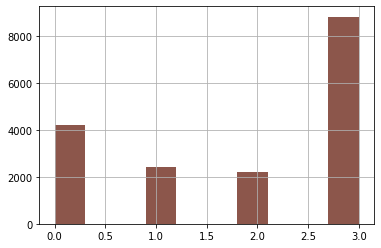

In [45]:
cat_model = Catb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

Found `n_estimators` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.03085	valid_1's rmse: 1.05801
[200]	training's rmse: 0.962841	valid_1's rmse: 1.01242
[300]	training's rmse: 0.928459	valid_1's rmse: 0.998127
[400]	training's rmse: 0.904904	valid_1's rmse: 0.991897
[500]	training's rmse: 0.885444	valid_1's rmse: 0.988318
[600]	training's rmse: 0.868446	valid_1's rmse: 0.986351
[700]	training's rmse: 0.853284	valid_1's rmse: 0.985134
[800]	training's rmse: 0.839324	valid_1's rmse: 0.98448
[900]	training's rmse: 0.826503	valid_1's rmse: 0.98381
[1000]	training's rmse: 0.81416	valid_1's rmse: 0.983383
[1100]	training's rmse: 0.802462	valid_1's rmse: 0.982991
[1200]	training's rmse: 0.791606	valid_1's rmse: 0.982777
[1300]	training's rmse: 0.781164	valid_1's rmse: 0.982687
Early stopping, best iteration is:
[1294]	training's rmse: 0.781786	valid_1's rmse: 0.982613
Partial score of fold 0 is: 0.5916716082681062
Training until validation scores don't improve for 100 roun

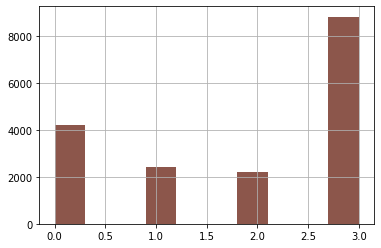

In [46]:
# solve: LightGBMError: Do not support special JSON characters in feature name.
reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
ajusted_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in ajusted_test.columns]
features = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features]

lgb_model = Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

In [ ]:
xgb_model = Xgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

Series.base is deprecated and will be removed in a future version


[0]	train-rmse:1.85633	val-rmse:1.85724
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.


In [ ]:
cnn_model = Cnn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

In [ ]:
nn_model = Nn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

In [ ]:
weights = {'lgb': 0.60, 'cat': 0, 'xgb': 0.20, 'nn': 0.20}

final_pred = (lgb_model.y_pred * weights['lgb']) + (xgb_model.y_pred * weights['xgb']) + (nn_model.y_pred * weights['nn'])
#final_pred = cnn_model.y_pred
print(final_pred.shape)

In [ ]:
weights = {'lgb': 0.60, 'cat': 0, 'xgb': 0.20, 'nn': 0.20}

final_pred = (lgb_model.y_pred * weights['lgb']) + (xgb_model.y_pred * weights['xgb']) + (nn_model.y_pred * weights['nn'])
#final_pred = cnn_model.y_pred
print(final_pred.shape)

(1000,)


{0: 1.2838145348539054, 1: 1.7117445607018082, 2: 1.9360381918245593}


3    0.500
0    0.239
1    0.136
2    0.125
Name: accuracy_group, dtype: float64

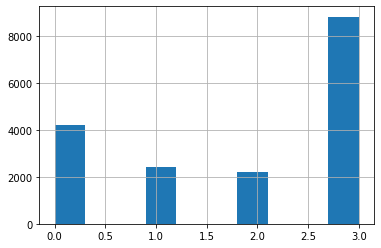

In [54]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)